In [1]:
# A script for me to explain the correlation between thermo and kinetics to myself

## (Some) reaction rates depend on species thermo

$k=AT^be^{-E_a/RT}$

For BEP relations, $E_a$ is a function of the enthalpy of reaction, which depends on species enthalpies

$E_a$ = $E_a(\Delta H_{rxn}) = E_0 + \alpha \Delta H_{rxn} = E_0 + \alpha \sum_i {\nu_i} H_{i}$

Where ${\nu_i}$ is the stoichiometric coefficient and $H_{i}$ is the enthalpy for species $i$.

We can rewrite this as a sum using properties of logs

$\ln k=\ln A +b\ln T - \frac{E_0}{RT} - \alpha \frac{\sum_i {\nu_i} H_{i}}{RT}$

# Each term is an independent source of uncertainty

(This isn't entirely accurate because species calculated using the same DFT method will have correlated/systematic errors, but it's the best we can do without digging into the details of
the BEEF-vdW results. Also, if the reactions are part of the same family, the $E_0$s are probably also correlated.)

We assume each term is independent of the others: $A, b, E_0, H_i$

(Assuming here that $\alpha$ isn't uncertain)

So, if we have two reactions:

$$\ln k_1=\ln A_1 +b_1\ln T - \frac{E_{0,1}}{RT} - \alpha_1 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

$$\ln k_2=\ln A_2 +b_2\ln T - \frac{E_{0,2}}{RT} - \alpha_2 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

and want to know the covariance between them $cov(\ln k_1, \ln k_2)$

The assumptions of independence mean that the only the $\alpha_1 \frac{{\nu_i} H_{i}}{RT}$ terms will be nonzero, and only when the same species appears in both reactions.

# Let's look at an example in RMG

In [9]:
import os
import numpy as np
import rmgpy.data.thermo
import matplotlib.pyplot as plt
%matplotlib inline

### Load the database

In [10]:
# Load the database
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = ['surfaceThermoPt111', 'primaryThermoLibrary'],
    reaction_libraries = ['Surface/CPOX_Pt/Deutschmann2006_adjusted'],
    kinetics_families = ['Surface_Abstraction'],
    kinetics_depositories = ['training'],
    depository = True,
)

### Define/display our example reactions

Reaction 1: CH2X + HOX <=> CH3X + OX

Reaction 2: CHX + HOX <=> CH2X + OX


Reaction 1:


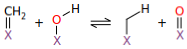


Reaction 2:


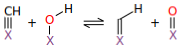


Reaction 3:


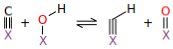


Reaction 4:


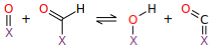

In [41]:
family = 'Surface_Abstraction'
training_depository = database.kinetics.families[family].get_training_depository()
my_reactions = []
for i, entry in enumerate(training_depository.entries):
    print(f'Reaction {i + 1}:')
    display(training_depository.entries[entry].item)
    my_reactions.append(training_depository.entries[entry].item)
    print()

### Look up the BEP kinetics corresponding to each reaction

Note that the training reactions themselves have regular Arrhenius kinetics.
We need to use RMG's kinetics decision tree to get the BEP version.

In [45]:
# Get the kinetics from the RMG family's decision tree
for i, rxn in enumerate(my_reactions):
    print(f'Reaction {i + 1}:')
    
    template_labels = database.kinetics.families[family].get_reaction_template_labels(rxn)
    template = database.kinetics.families[family].retrieve_template(template_labels)
    kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=rxn.degeneracy)[0]
    my_reactions[i].kinetics = kinetics
    print(kinetics)
    print()

Reaction 1:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C=*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 2:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C#*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 3:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C$*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 4:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.94, E0=(129.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using te

Note that 3/4 of the examples have identical BEP parameters, but will have different $\ln k$
because of the dependence on $\Delta H_{rxn}$

### Grab the species thermo from the database so we can calculate $\Delta H_{rxn}$

In [56]:
lib = database.thermo.libraries['surfaceThermoPt111']
for i, rxn in enumerate(my_reactions):
    for j in range(len(rxn.reactants)):
        my_reactions[i].reactants[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].reactants[j],
            lib
        )[0]
    for j in range(len(rxn.products)):
        my_reactions[i].products[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].products[j],
            lib
        )[0]

# Plot the kinetics to see what they are

In [117]:
def plot_kinetics(rxns, labels=None, title=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')
    linestyles = ['solid', 'dashed', 'dotted', 'solid']
    if type(rxns) != list:
        rxns = [rxns]
    P = 101325
    T = np.linspace(300, 3000, 1001)
    for j, rxn in enumerate(rxns):
        Tmax = max(T)
        if hasattr(rxn, 'reactants'):
            Tmax = min([sp.thermo.Tmax.value_si for sp in rxn.reactants + rxn.products])
        k = np.zeros(len(T)) * np.nan
        for i in range(0, len(T)):
            if T[i] > Tmax:
                break
            if type(rxn) == rmgpy.kinetics.surface.SurfaceArrhenius:
                k[i] = rxn.get_rate_coefficient(T[i], P)
            else:
                my_reactions[0].reactants[0].thermo.Tmax.value_si
                k[i] = rxn.kinetics.get_rate_coefficient(T[i], dHrxn=rxn.get_enthalpy_of_reaction(T[i]))

            
        plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[j % len(linestyles)])

    if labels:
        plt.legend(labels)
    if title:
        plt.title(title)
#     plt.show()

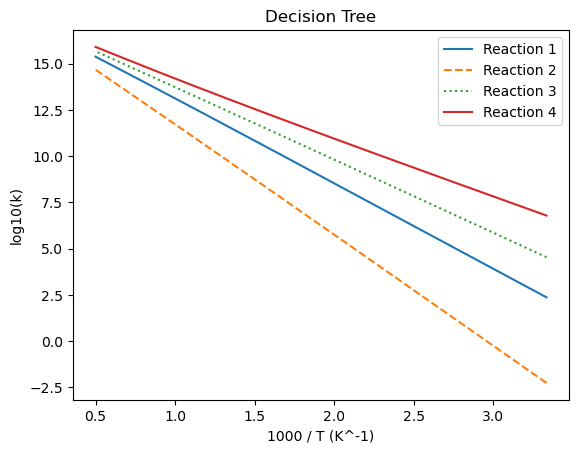

In [120]:
# show kinetics
plot_kinetics(my_reactions, labels=[f'Reaction {i}' for i in range(1, 5)], title='Decision Tree')


In [122]:
# # Shows that training reaction kinetics don't necessary match decision tree kinetics exactly
# training_kinetics = [training_depository.entries[entry].data for entry in training_depository.entries]
# plot_kinetics(my_reactions + training_kinetics, labels=[f'Decision {i}' for i in range(1, 5)] + [f'Training {i}' for i in range(1, 5)])

# Do the theoretical calculation and see how it compares to random sampling

For simplicity, I will assume all the uncertainty is in the species enthalpies.

We can add in the uncertainty from A, b, and E0 later

We have already assumed those are all uncorrelated to each other (or at least uncorrelated to the values in other nodes in the decision tree)

## Define our species indices and uncertainties

0



1


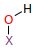


2


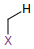


3



4



5



6


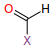


7


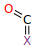

In [126]:
def species_in_list(new_species, species_list):
    for sp in species_list:
        if new_species.is_isomorphic(sp):
            return True
    return False

def get_species_index(query_species, species_list):
    for i in range(len(species_list)):
        if query_species.is_isomorphic(species_list[i]):
            return i
    return -1

species = []

for rxn in my_reactions:
    for s in rxn.reactants + rxn.products:
        if not species_in_list(s, species):
            species.append(s)
for i in range(len(species)):
    print(i)
    display(species[i])
    print()

Recall we had

$$\ln k_m=\ln A_m +b_m\ln T - \frac{E_{0,m}}{RT} - \alpha_m \frac{\sum_i {\nu_i} H_{i}}{RT}$$

Variance of $\ln k_m$ is denoted as $Var(\ln k_m)$ and sometimes ${(\Delta \ln k_m)}^2$

Standard deviation of $\ln k_m$ is denoted as $Std(\ln k_m)$ and sometimes $\Delta \ln k_m$

Covariance of $\ln k_m$ and $\ln k_n$, or $Cov(\ln k_m, \ln k_n)$ will be a sum of variance terms where the $\alpha_m \frac{ {\nu_i} H_{i}}{RT}$ parts match up

$$Cov(\ln k_m, \ln k_n) = \frac{\alpha_m \alpha_n}{{(RT)}^2} \sum_i^{rxn_m} \sum_j^{rxn_n} \delta_{sp,i}\delta_{sp,j} \nu_i \nu_j {Var(H_i)}$$


## Build the Covariance Matrix

In [128]:
cov_matrix_theory = np.zeros((len(my_reactions), len(my_reactions)))

In [134]:
rmgpy.constants.R

8.314472

In [142]:
varH = np.float_power(6.918, 2.0) ## 0.3 eV squared
R = 8.314472
T = 1000.0
for i in range(len(my_reactions)):
    for j in range(len(my_reactions)):
        rxn_i = my_reactions[i]
        rxn_j = my_reactions[j]
        for k in range(len(species)):
            if species_in_list(species[k], rxn_i.reactants):
                nu_i = -1
            elif species_in_list(species[k], rxn_i.products):
                nu_i = 1
            else:
                nu_i = 0
                
            if species_in_list(species[k], rxn_j.reactants):
                nu_j = -1
            elif species_in_list(species[k], rxn_j.products):
                nu_j = 1
            else:
                nu_j = 0
            
            alpha_i = my_reactions[i].kinetics.alpha.value_si
            alpha_j = my_reactions[j].kinetics.alpha.value_si
            cov_matrix_theory[i, j] += nu_i * nu_j * alpha_i * alpha_j * varH / np.float_power(R * T, 2.0)

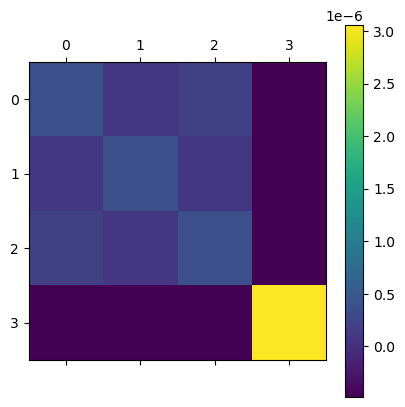

In [144]:
plt.matshow(cov_matrix_theory)
plt.colorbar()


## Start with $Cov(\ln k_1, \ln k_1) = Var(\ln k_1)$

### Get the species indices

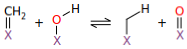

In [127]:
rxn_i = my_reactions[0]
rxn_j = my_reactions[0]

for i in range(len(species)):
    

my_reactions[0]

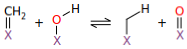

In [125]:
my_reactions[0]

In [ ]:
# Each of the species comes from a surface library assumed to have 0.3eV for 1 std dev in uncertainty




In [20]:
type(training_depository.entries[24].data)

rmgpy.kinetics.surface.SurfaceArrhenius

In [5]:
train = database.kinetics.families['Surface_Abstraction'].get_training_depository()

In [11]:
str(train.entries[24].item)

'CH2X_1 + HOX_3 <=> CH3X_4 + OX_5'

In [12]:
str(train.entries[26].item)

'CHX_1 + HOX_3 <=> CH2X_4 + OX_5'

In [ ]:
train.entries[28].item

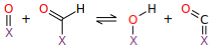

In [15]:
train.entries[39].item

In [ ]:
train.entries

In [ ]:
train.entries[39].item.reactants[0]

In [ ]:
print(train.entries[39].item.reactants[0].to_adjacency_list())

In [ ]:
train.entries[24].item.products[1]

In [ ]:
print(train.entries[24].item.products[1].to_adjacency_list())